<h2> Digit Classification with SoftMax activation function </h2>

The MNIST dataset was used to train a neural network having a single linear layer with SoftMax employed in the criterion function (Cross Entropy Loss) to classify handwritten digits in classes 0 to 9.

In [1]:
import torch 
from torch import nn, optim
from torchvision.transforms import ToTensor
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:
# Plotting the Softmax function

def plotpara(model):
    W = model.state_dict()['linear.weight'].data
    wmin = W.min().item()
    wmax = W.max().item()
    fig, axes = plt.subplots(2,5)
    fig.subplots_adjust(hspace = 0.01, wspace = 0.1)

    for i, ax in enumerate(axes.flat):
        if i < 10:
            ax.set_xlabel('class: ' + str(i))
            ax.imshow(W[i,:].view(28,28), vmin=wmin, vmax=wmax, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.show()

In [3]:
# Plotting data sample

def showme(sample):
    plt.imshow(sample[0].numpy().reshape(28,28), cmap='gray')
    plt.title('y = ' + str(sample[1]))
    plt.show()

The training and validation sets will be downloaded from the MNIST database.

In [4]:
trainset = dsets.MNIST(root='./data', download=True, transform=ToTensor())
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
valset = dsets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
valset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
len(trainset), len(valset)

(60000, 10000)

Now we will define our single layer neural network with nn.Module

In [7]:
class softmax(nn.Module):

    def __init__(self, ipsize, opsize):
        super(softmax, self).__init__()
        self.linear = nn.Linear(ipsize, opsize)

    def forward(self, x):
        return self.linear(x)

Checking and setting input-output sizes

In [8]:
trainset[0][0].shape

torch.Size([1, 28, 28])

In [9]:
ipsize = 28*28
opsize = 10

In [10]:
# Model definition
model = softmax(ipsize, opsize)
model

softmax(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)

In [11]:
print('w:', list(model.parameters())[0].size())
print('b:', list(model.parameters())[1].size())

w: torch.Size([10, 784])
b: torch.Size([10])


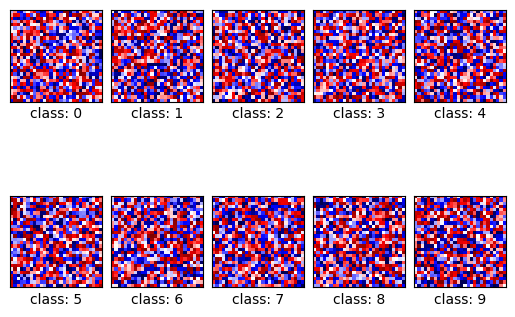

In [12]:
# Randomly initialised model parameters
plotpara(model)

In [13]:
# Input image will have to be reformatted in the shape expected by our model
X = trainset[0][0].view(-1, 28*28)
X.shape

torch.Size([1, 784])

In [14]:
model(X)

tensor([[-0.3762, -0.2720, -0.0840, -0.2737, -0.1112, -0.1134, -0.1108,  0.1623,
          0.4998,  0.1478]], grad_fn=<AddmmBackward0>)

The model will output the function values of the input image array for each digit's equation. 

It is worthwhile to note the model output is <b>not</b> probability.

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(trainset, 100)
valloader = DataLoader(valset, 5000)

This is where SoftMax is employed by the criterion function to convert the model output to probabilities of each class being assigned to the input image.

In [16]:
pred = model(X)
actual = torch.tensor([trainset[0][1]])

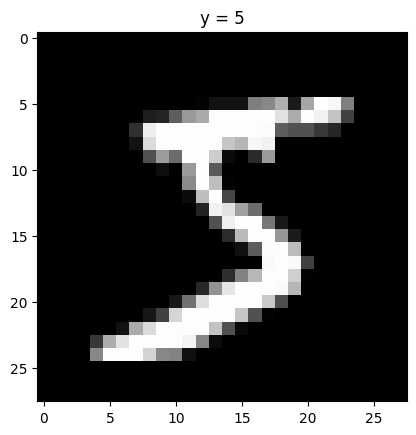

In [17]:
showme(trainset[0])

In [18]:
pred

tensor([[-0.3762, -0.2720, -0.0840, -0.2737, -0.1112, -0.1134, -0.1108,  0.1623,
          0.4998,  0.1478]], grad_fn=<AddmmBackward0>)

In [19]:
actual

tensor([5])

In [20]:
criterion(pred, actual)

tensor(2.3953, grad_fn=<NllLossBackward0>)

Therefore, the actual image class is compared to the probability values of the model output using the Cross Entropy Loss criterion function.

<h3>Training and Validation </h3>

We will train our model on the entire training dataset and check the loss and accuracy values in each epoch of the training iteration.

In [21]:
LOSS = []
ACC = []
testsize = len(valset)

def trainmodel(iter):
    for epoch in range(iter):

        # Training
        for x,y in trainloader:
            yhat = model(x.view(-1, 28*28))
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        LOSS.append(loss.item())

        # Validation
        # Increment 'count' for every correct prediction in validation dataset
        correct = 0
        for xtest, ytest in valloader:
            pred = model(xtest.view(-1,28*28))
            _, yhat = torch.max(pred.data, 1)
            correct += (yhat==ytest).sum().item() 
        acc = correct/testsize
        ACC.append(acc)

In [22]:
# Model training (may take a few minutes)
trainmodel(10)

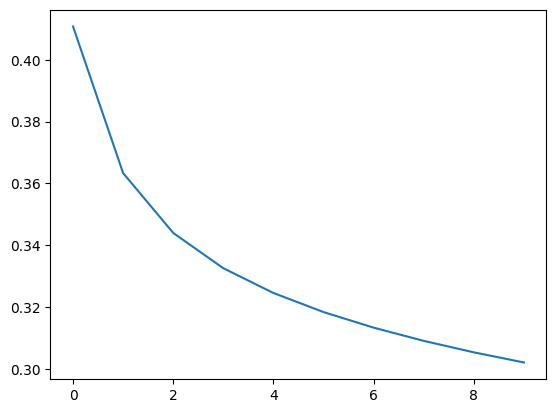

In [23]:
# Plot loss after each training epoch
plt.plot(LOSS)

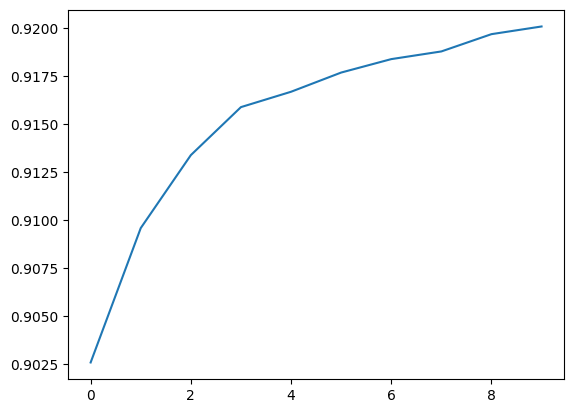

In [24]:
# Plot accuracy after each validation epoch
plt.plot(ACC)

Let's visualise the model parameters after training.

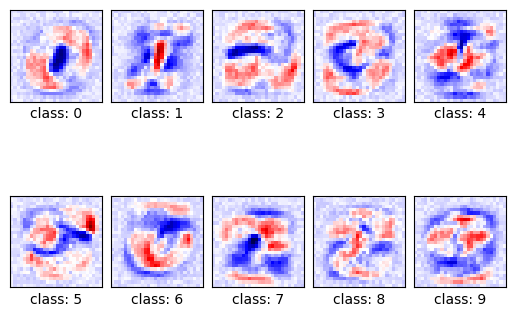

In [25]:
plotpara(model)

Let's check out the first 5 incorrectly classified samples

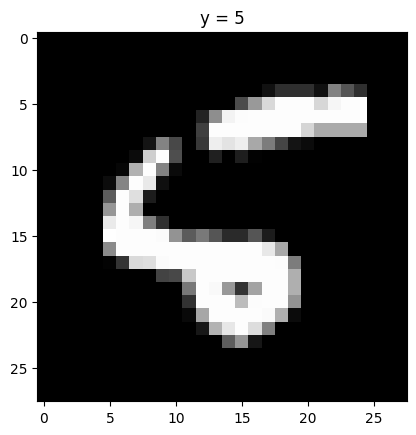

yhat: tensor([6])
probability of class: 0.9900966882705688


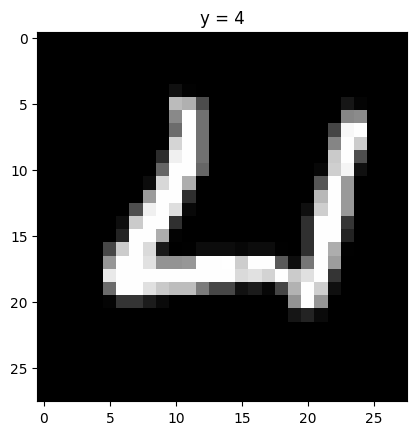

yhat: tensor([6])
probability of class: 0.4389501214027405


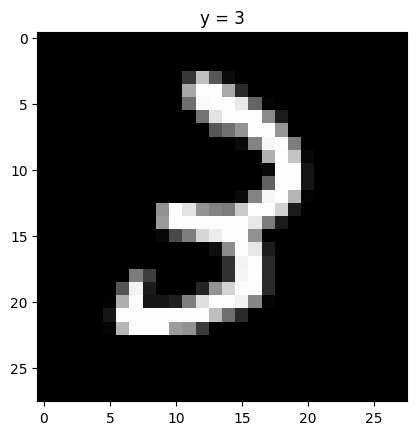

yhat: tensor([2])
probability of class: 0.684048056602478


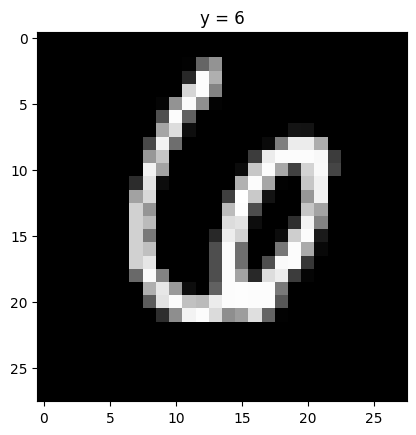

yhat: tensor([7])
probability of class: 0.3359088897705078


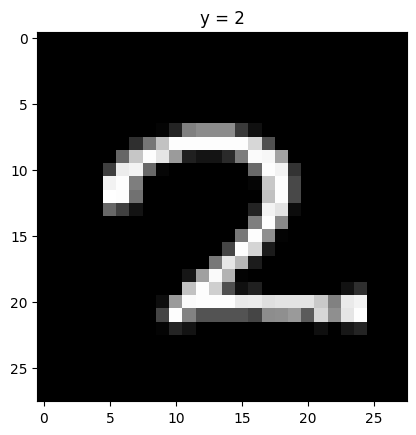

yhat: tensor([7])
probability of class: 0.5405083894729614


In [26]:
soft = nn.Softmax(-1)
count = 0
for x,y in valset:
    z = model(x.reshape(-1,28*28))
    _, yhat = torch.max(z, 1)
    if yhat != y:
        showme((x,y))
        print("yhat:", yhat)
        print("probability of class:", torch.max(soft(z)).item())
        count += 1
    if count >= 5:
        break

Let's check out the first five correcty classified samples

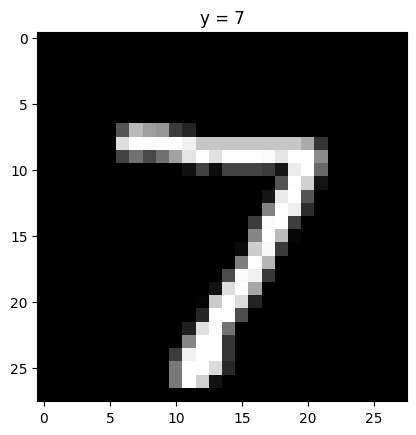

yhat: tensor([7])
probability of class: 0.9968051910400391


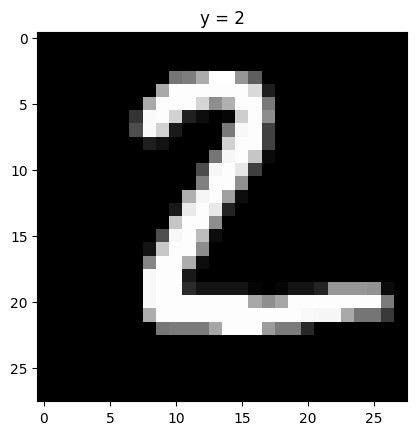

yhat: tensor([2])
probability of class: 0.9473180174827576


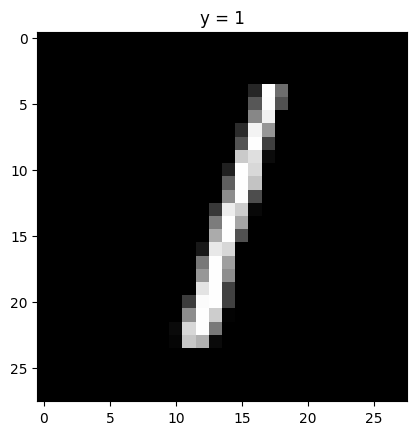

yhat: tensor([1])
probability of class: 0.9764031171798706


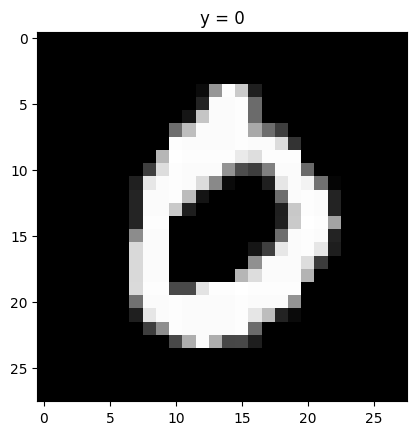

yhat: tensor([0])
probability of class: 0.9995813965797424


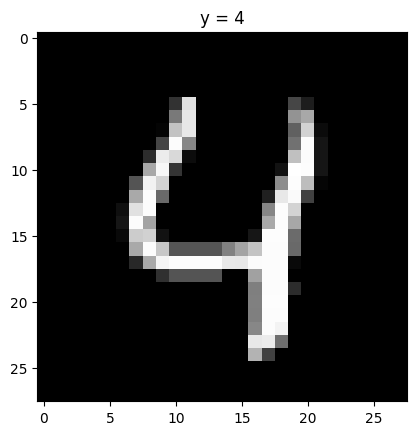

yhat: tensor([4])
probability of class: 0.9520531892776489


In [27]:
count = 0
for x,y in valset:
    z = model(x.reshape(-1,28*28))
    _, yhat = torch.max(z, 1)
    if yhat == y:
        showme((x,y))
        print("yhat:", yhat)
        print("probability of class:", torch.max(soft(z)).item())
        count += 1
    if count >= 5:
        break